# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=2dc5bd41a64982f084a8ab6f10e04680c7b7c0590f8d4c37d9a8bd162ce74689
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=1fb40bd5c32fd038e2696e89f55ec44cb86d1ee40ef9a38ae77dcae64a8ca8c9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.


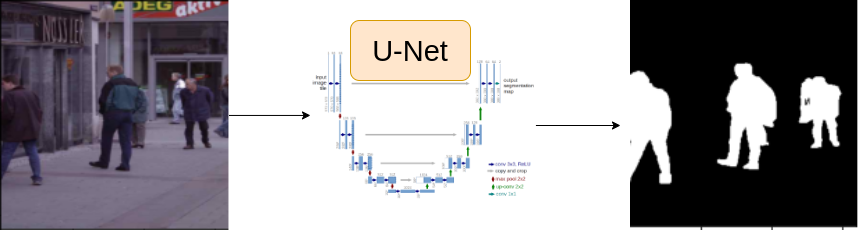

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cuda"
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(row.images)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
print(mask)
print(type(mask))

(183, 276, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>


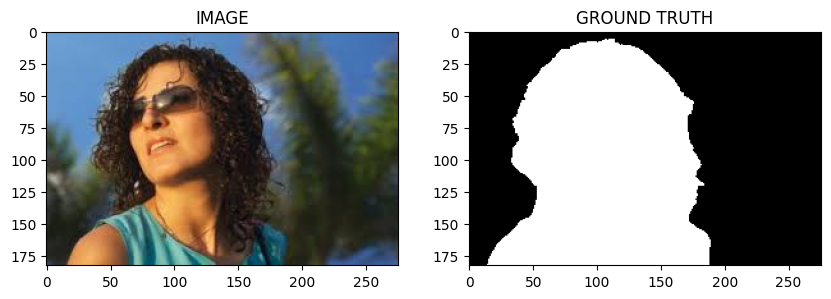

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
train_df.iloc[3].masks

'Human-Segmentation-Dataset-master/Ground_Truth/73.png'

In [11]:
train_df.loc[:,"masks"]

,masks
6,Human-Segmentation-Dataset-master/Ground_Truth...
209,Human-Segmentation-Dataset-master/Ground_Truth...
223,Human-Segmentation-Dataset-master/Ground_Truth...
261,Human-Segmentation-Dataset-master/Ground_Truth...
73,Human-Segmentation-Dataset-master/Ground_Truth...
...,...
188,Human-Segmentation-Dataset-master/Ground_Truth...
71,Human-Segmentation-Dataset-master/Ground_Truth...
106,Human-Segmentation-Dataset-master/Ground_Truth...
270,Human-Segmentation-Dataset-master/Ground_Truth...


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5), #this will randomly flip the image horizontally with a probability of 0.5
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes = False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ], is_check_shapes=False)

  #get_train_augs() and get_valid_augs() has is_check_shapes argument set to false as the augmentation pipeline already includes resize the images
  #image and masks dimension must match due to pixel-wise correspondence for masks and images

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):
  '''
  According to the pytorch docs
  A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.
  '''

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # mask = np.expand_dims(mask, axis = -1)
    #np.expand_dims is depracated
    mask = np.reshape(mask, newshape=(mask.shape[0], mask.shape[1], 1))

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data["image"]
      mask = data["mask"]

    #(h,w,c) -> (c,h,w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [16]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


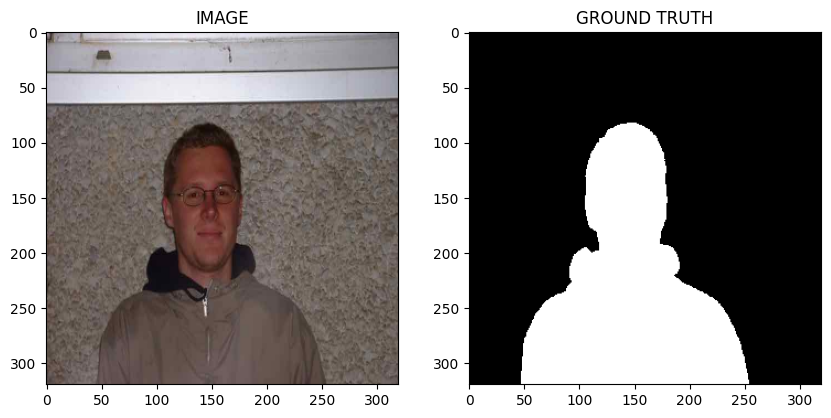

In [18]:
idx = 31
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [21]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [22]:
for image,mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [24]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights =  WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)
    #logit refers to the raw output of a model before any activation function is applied
    #logit is the input to the sigmoid function in log reg
    #self.arc is an instance of a model class that inherits from nn.Module which is callable
    #all classes taht inherit from nn.Module need to implement the forward method
    #since self.arc is callable, it will call the __call__(images)

    if masks != None:
      loss1 = DiceLoss(mode = "binary")(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [25]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 101MB/s] 


# Task 7 : Create Train and Validation Function

In [26]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    #tqdm is used for the progress bar
    #i am transferring the batch of images and masks to the device to ensure computation is performed on the right device

    optimizer.zero_grad()
    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)


In [27]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)


# Task 8 : Train Model

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [29]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i + 1} Train_loss : {train_loss} Valid_loss : {valid_loss}")


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.7844949841499329 Valid_loss : 2.7077797055244446


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.4102000693480174 Valid_loss : 0.4293792024254799


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


SAVED-MODEL
Epoch : 3 Train_loss : 0.3344057619571686 Valid_loss : 0.39808039367198944


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.28689219256242116 Valid_loss : 0.38488008081912994


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.2441311001777649 Valid_loss : 0.2641681842505932


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED-MODEL
Epoch : 6 Train_loss : 0.22591719031333923 Valid_loss : 0.22214581817388535


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch : 7 Train_loss : 0.1991929401954015 Valid_loss : 0.2501968555152416


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 8 Train_loss : 0.1910450577735901 Valid_loss : 0.2260277234017849


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


Epoch : 9 Train_loss : 0.17246644149223964 Valid_loss : 0.24731294810771942


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED-MODEL
Epoch : 10 Train_loss : 0.16173003613948822 Valid_loss : 0.20629426464438438


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch : 11 Train_loss : 0.16882186432679494 Valid_loss : 0.28494495153427124


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


SAVED-MODEL
Epoch : 12 Train_loss : 0.18115791529417039 Valid_loss : 0.19500136375427246


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 13 Train_loss : 0.17388981382052104 Valid_loss : 0.2316378951072693


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 14 Train_loss : 0.149235400557518 Valid_loss : 0.211753960698843


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


SAVED-MODEL
Epoch : 15 Train_loss : 0.1353251372774442 Valid_loss : 0.17818764224648476


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


SAVED-MODEL
Epoch : 16 Train_loss : 0.11584662894407909 Valid_loss : 0.1579875573515892


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch : 17 Train_loss : 0.11678508818149566 Valid_loss : 0.1611490324139595


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch : 18 Train_loss : 0.12985608528057735 Valid_loss : 0.18316121399402618


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch : 19 Train_loss : 0.1254135345419248 Valid_loss : 0.23480700328946114


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch : 20 Train_loss : 0.1377021238207817 Valid_loss : 0.20256230607628822


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 21 Train_loss : 0.101506906747818 Valid_loss : 0.20205024257302284


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch : 22 Train_loss : 0.10939885626236598 Valid_loss : 0.18995171785354614


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 23 Train_loss : 0.13845135122537613 Valid_loss : 0.21838536486029625


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Epoch : 24 Train_loss : 0.11890113453070322 Valid_loss : 0.24888058379292488


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

Epoch : 25 Train_loss : 0.1122129037976265 Valid_loss : 0.1730910688638687


# Task 9 : Inference

In [30]:
idx = 20

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
#moving the image tensor to the same device as the one for model for computation
#unsqueeze(0) adds a new dimension at the bgining of the tensor

pred_mask = torch.sigmoid(logits_mask)
#applies the sigmoid function on the output logits from the model
#values are between 0 and 1

pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-30-fc4d5c1e06b0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model.pt"))


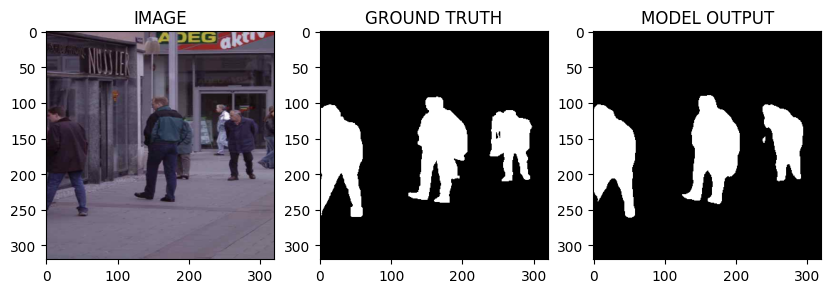

In [31]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))